In [149]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re

try:
    stopwords.words('dutch')
except LookupError:
    nltk.download('stopwords', quiet=True)

df = pd.read_csv('Uitgebreide_VKM_dataset.csv')
df.drop_duplicates(inplace=True); pd.set_option('display.max_columns', None)


## Exploratory Data Analysis (EDA)

In [150]:
# Dataset overview
print("Dataset shape:", df.shape)
print("\nKolomnamen:")
print(df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Dataset shape: (211, 20)

Kolomnamen:
['id', 'name', 'shortdescription', 'description', 'content', 'studycredit', 'location', 'contact_id', 'level', 'learningoutcomes', 'Rood', 'Groen', 'Blauw', 'Geel', 'module_tags', 'interests_match_score', 'popularity_score', 'estimated_difficulty', 'available_spots', 'start_date']

Data types:
id                         int64
name                      object
shortdescription          object
description               object
content                   object
studycredit                int64
location                  object
contact_id                 int64
level                     object
learningoutcomes          object
Rood                     float64
Groen                    float64
Blauw                    float64
Geel                     float64
module_tags               object
interests_match_score    float64
popularity_score           int64
estimated_difficulty       int64
available_spots            int64
start_date                object
dtype: 

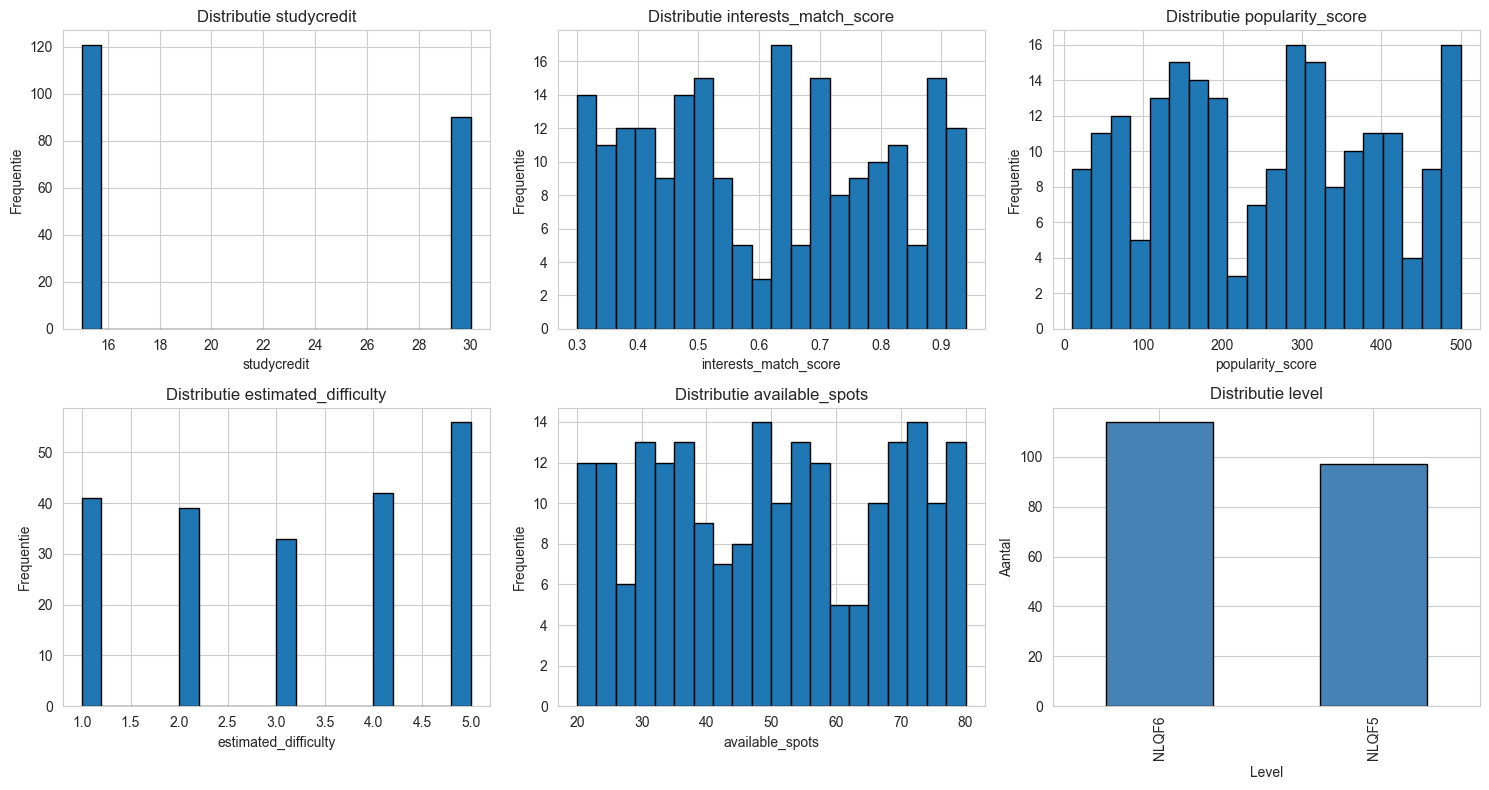

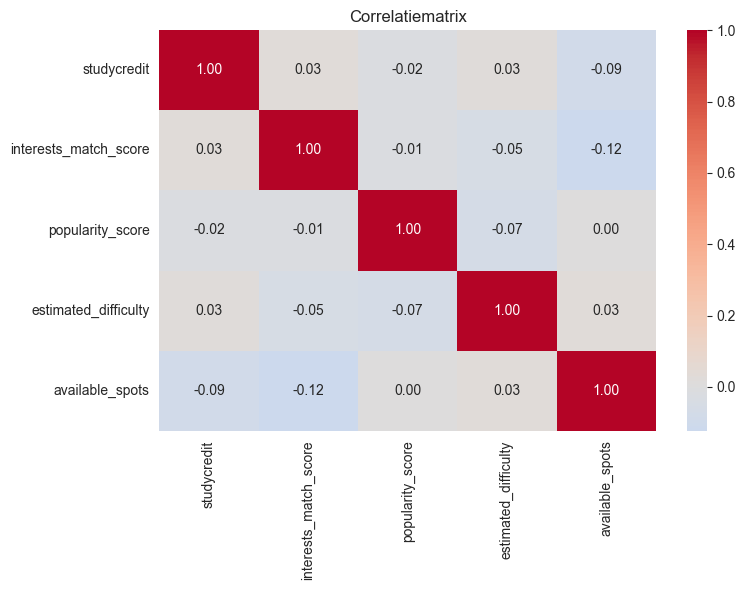

In [151]:
# Visualisaties
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Selecteer relevante numerieke kolommen (zonder Rood/Groen/Blauw/Geel en id's)
numeric_cols = ['studycredit', 'interests_match_score', 'popularity_score', 
                'estimated_difficulty', 'available_spots']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    df[col].hist(bins=20, ax=axes[idx], edgecolor='black')
    axes[idx].set_title(f'Distributie {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequentie')

# Categorical variables
df['level'].value_counts().plot(kind='bar', ax=axes[5], color='steelblue', edgecolor='black')
axes[5].set_title('Distributie level')
axes[5].set_xlabel('Level')
axes[5].set_ylabel('Aantal')

plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(8, 6))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlatiematrix')
plt.tight_layout()
plt.show()

Locatie distributie:
location
Breda                   105
Den Bosch                55
Breda en Den Bosch       28
Den Bosch en Tilburg     15
Tilburg                   8
Name: count, dtype: int64


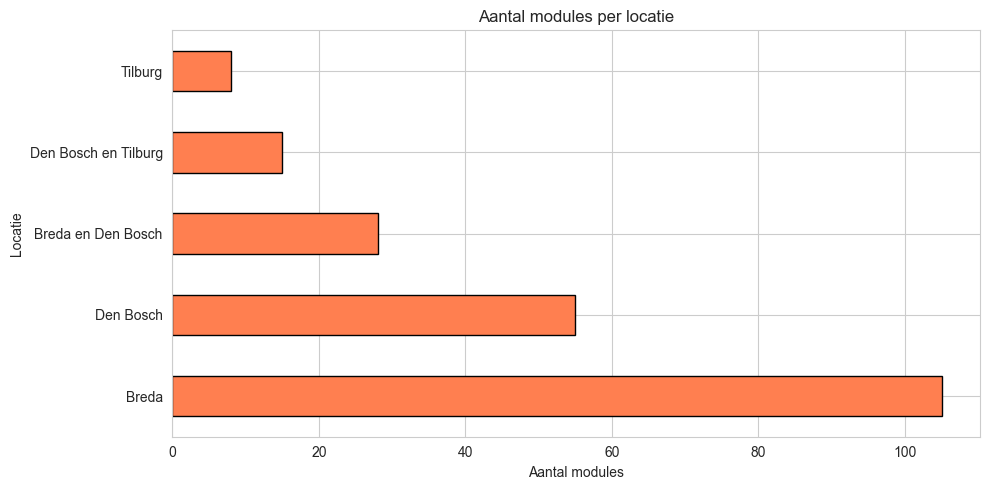

In [152]:
# Locatie analyse
print("Locatie distributie:")
location_counts = df['location'].value_counts()
print(location_counts)

plt.figure(figsize=(10, 5))
location_counts.plot(kind='barh', color='coral', edgecolor='black')
plt.title('Aantal modules per locatie')
plt.xlabel('Aantal modules')
plt.ylabel('Locatie')
plt.tight_layout()
plt.show()

Gemiddelde studycredits per level:
            mean  count
level                  
NLQF5  15.309278     97
NLQF6  26.578947    114


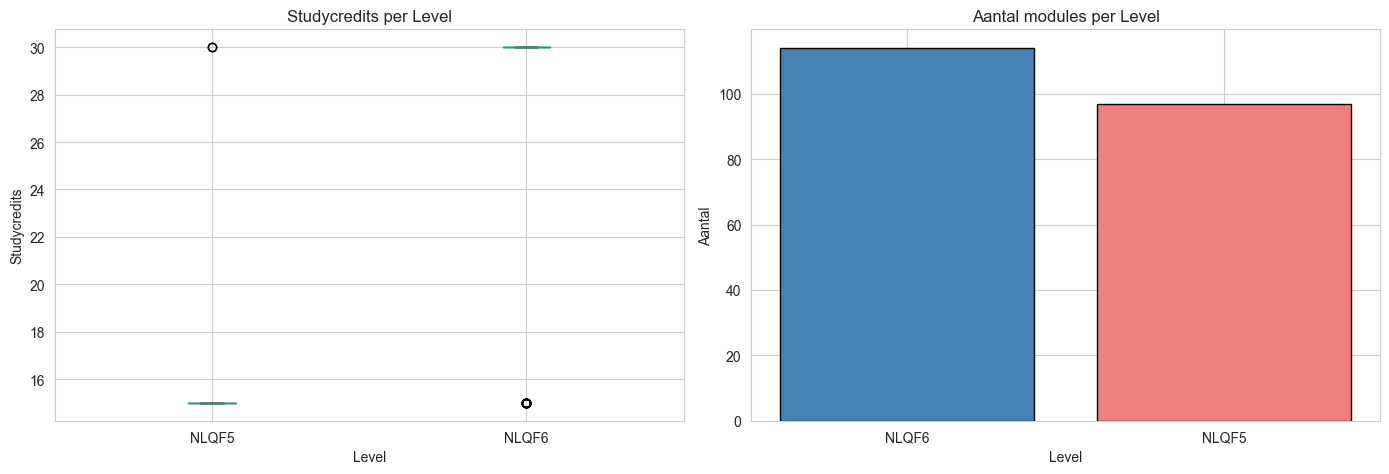

In [153]:
# Studycredit vs Level analyse
print("Gemiddelde studycredits per level:")
credits_per_level = df.groupby('level')['studycredit'].agg(['mean', 'count'])
print(credits_per_level)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
df.boxplot(column='studycredit', by='level', ax=axes[0])
axes[0].set_title('Studycredits per Level')
axes[0].set_xlabel('Level')
axes[0].set_ylabel('Studycredits')
plt.suptitle('')

# Count plot
level_counts = df['level'].value_counts()
axes[1].bar(level_counts.index, level_counts.values, color=['steelblue', 'lightcoral'], edgecolor='black')
axes[1].set_title('Aantal modules per Level')
axes[1].set_xlabel('Level')
axes[1].set_ylabel('Aantal')

plt.tight_layout()
plt.show()

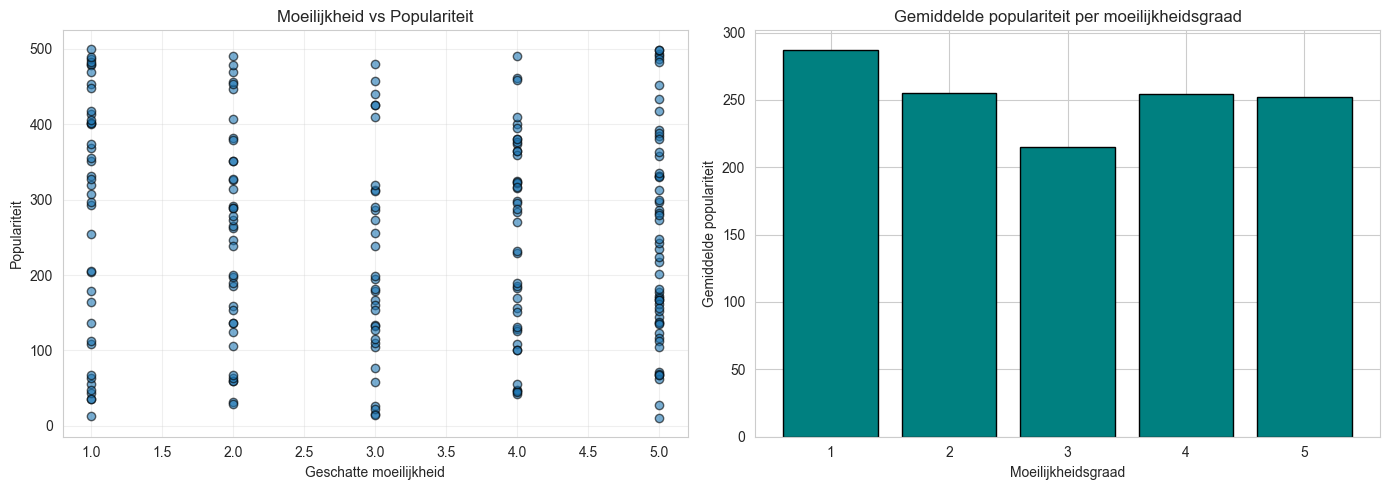


Gemiddelde populariteit per moeilijkheidsgraad:
estimated_difficulty
1    287.2
2    255.5
3    215.0
4    254.3
5    252.4
Name: popularity_score, dtype: float64


In [154]:
# Moeilijkheid vs Populariteit
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(df['estimated_difficulty'], df['popularity_score'], alpha=0.6, edgecolor='black')
axes[0].set_xlabel('Geschatte moeilijkheid')
axes[0].set_ylabel('Populariteit')
axes[0].set_title('Moeilijkheid vs Populariteit')
axes[0].grid(alpha=0.3)

# Gemiddelde populariteit per moeilijkheidsgraad
pop_per_difficulty = df.groupby('estimated_difficulty')['popularity_score'].mean()
axes[1].bar(pop_per_difficulty.index, pop_per_difficulty.values, color='teal', edgecolor='black')
axes[1].set_xlabel('Moeilijkheidsgraad')
axes[1].set_ylabel('Gemiddelde populariteit')
axes[1].set_title('Gemiddelde populariteit per moeilijkheidsgraad')

plt.tight_layout()
plt.show()

print("\nGemiddelde populariteit per moeilijkheidsgraad:")
print(pop_per_difficulty.round(1))

Interest match score statistieken:
  Gemiddelde: 0.61
  Mediaan: 0.62
  Min: 0.30
  Max: 0.94

Verdeling interest scores:
interests_match_score
Laag (0-0.4)           41
Gemiddeld (0.4-0.7)    93
Hoog (0.7-1.0)         77
Name: count, dtype: int64


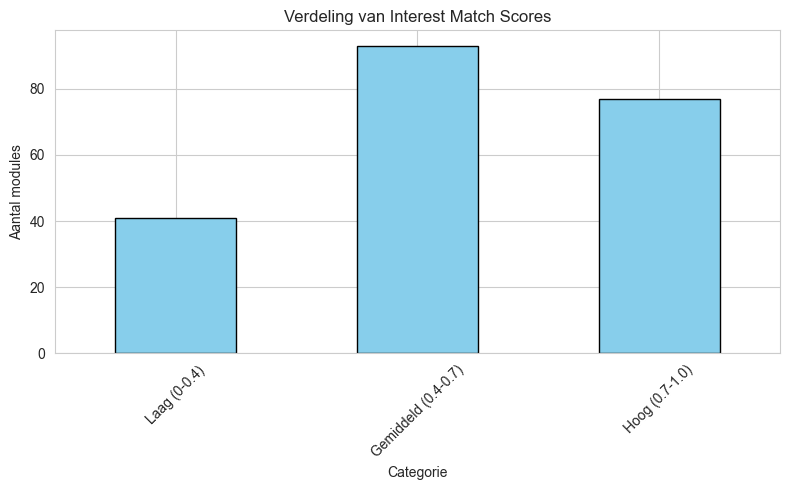

In [155]:
# Interest match score analyse
print("Interest match score statistieken:")
print(f"  Gemiddelde: {df['interests_match_score'].mean():.2f}")
print(f"  Mediaan: {df['interests_match_score'].median():.2f}")
print(f"  Min: {df['interests_match_score'].min():.2f}")
print(f"  Max: {df['interests_match_score'].max():.2f}")

# Categoriseer voor visualisatie
interest_categories = pd.cut(df['interests_match_score'], 
                              bins=[0, 0.4, 0.7, 1.0], 
                              labels=['Laag (0-0.4)', 'Gemiddeld (0.4-0.7)', 'Hoog (0.7-1.0)'])

interest_dist = interest_categories.value_counts().sort_index()
print(f"\nVerdeling interest scores:")
print(interest_dist)

plt.figure(figsize=(8, 5))
interest_dist.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Verdeling van Interest Match Scores')
plt.xlabel('Categorie')
plt.ylabel('Aantal modules')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## We vervangen alle lege/ntb waarden door 'Nog te bepalen'

In [ ]:
vooraf_ntb = {}
for col in df.columns:
    if df[col].dtype == 'object':
        vooraf_ntb[col] = (df[col] == 'Nog te bepalen').sum()

for col in df.columns:
    if df[col].dtype == 'object':
        for i in df.index:
            cell_value = str(df.loc[i, col]).strip()
            
            if col == 'module_tags':
                if cell_value in ['[]', "['ntb']", '["ntb"]', 'ntb']:
                    df.loc[i, col] = 'Nog te bepalen'
            else:
                if pd.isna(df.loc[i, col]) or cell_value == '' or cell_value.lower() in ['ntb', 'nog niet bekend', 'nog te formuleren']:
                    df.loc[i, col] = 'Nog te bepalen'

df.drop(['Rood', 'Groen', 'Blauw', 'Geel'], axis=1, inplace=True, errors='ignore')

print("\nNa standaardisatie met nog te bepalen waarden:")
for col in df.columns:
    if df[col].dtype == 'object':
        na_ntb = (df[col] == 'Nog te bepalen').sum()
        verschil = na_ntb - vooraf_ntb.get(col, 0)
        if verschil > 0:
            print(f"  {col}: {na_ntb}")


Na standaardisatie met nog te bepalen waarden:
  shortdescription: 30
  description: 4
  content: 4
  learningoutcomes: 55
  module_tags: 30


## We checken of description en content lang genoeg zijn (>30 karakters)

In [ ]:
print("Vooraf kwaliteitscontrole:")
print(f"  description 'Nog te bepalen': {(df['description'] == 'Nog te bepalen').sum()}")
print(f"  content 'Nog te bepalen': {(df['content'] == 'Nog te bepalen').sum()}")

for i in df.index:
    for col in ['description', 'content']:
        if df.loc[i, col] != 'Nog te bepalen':
            text_len = len(str(df.loc[i, col]).strip())
            if text_len <= 30:
                df.loc[i, col] = 'Nog te bepalen'

print("\nNa kwaliteitscontrole:")
print(f"  description 'Nog te bepalen': {(df['description'] == 'Nog te bepalen').sum()}")
print(f"  content 'Nog te bepalen': {(df['content'] == 'Nog te bepalen').sum()}")

Vooraf kwaliteitscontrole:
  description 'Nog te bepalen': 4
  content 'Nog te bepalen': 4

Na kwaliteitscontrole:
  description 'Nog te bepalen': 7
  content 'Nog te bepalen': 12


## Hier vullen we de shortdescription met de description + content als deze geen Nog te bepalen bevatten

In [ ]:
ntb_voor = (df['shortdescription'] == 'Nog te bepalen').sum()
print(f"Vooraf shortdescription 'Nog te bepalen': {ntb_voor}")

for i in df.index:
    if df.loc[i, 'shortdescription'] == 'Nog te bepalen':
        desc = str(df.loc[i, 'description']) if df.loc[i, 'description'] != 'Nog te bepalen' else ''
        cont = str(df.loc[i, 'content']) if df.loc[i, 'content'] != 'Nog te bepalen' else ''
        combined = (desc + ' ' + cont).strip()
        df.loc[i, 'shortdescription'] = combined if combined else 'Nog te bepalen'

ntb_na = (df['shortdescription'] == 'Nog te bepalen').sum()
print(f"Na vullen shortdescription 'Nog te bepalen': {ntb_na}")

Vooraf shortdescription 'Nog te bepalen': 30
Na vullen shortdescription 'Nog te bepalen': 4


## We vullen de module_tags in door belangrijke woorden te stelen uit de shortdescription. We skippen de niet belangrijke woorden!

In [ ]:
dutch_stops = set(stopwords.words('dutch'))

ntb_voor = (df['module_tags'] == 'Nog te bepalen').sum()
print(f"Vooraf module_tags 'Nog te bepalen': {ntb_voor}")

aangepaste_rijen = []

for i in df.index:
    if df.loc[i, 'module_tags'] == 'Nog te bepalen':
        aangepaste_rijen.append(i)
        
        text = str(df.loc[i, 'shortdescription'])
        woorden = re.findall(r'\b\w+\b', text.lower())
        tags = [w for w in woorden if w not in dutch_stops and len(w) >= 3 and w not in ['nog', 'bepalen']]
        
        if not tags:
            name_text = str(df.loc[i, 'name'])
            name_woorden = re.findall(r'\b\w+\b', name_text.lower())
            tags = [w for w in name_woorden if w not in dutch_stops and len(w) >= 3 and w not in ['nog', 'bepalen']]
        
        df.loc[i, 'module_tags'] = str(tags) if tags else "['algemeen']"

ntb_na = (df['module_tags'] == 'Nog te bepalen').sum()
print(f"Na vullen module_tags 'Nog te bepalen': {ntb_na}")
print(f"Aantal aangepaste rijen: {len(aangepaste_rijen)}")

Vooraf module_tags 'Nog te bepalen': 30
Na vullen module_tags 'Nog te bepalen': 0
Aantal aangepaste rijen: 30


## Exporten naar een nieuwe .csv bestand voor controle en een print van alle Nog te bepalen velden

In [ ]:
output_file = 'Opgeschoonde_VKM_dataset.csv'
df.to_csv(output_file, index=False, encoding='utf-8')

print("Resterende 'Nog te bepalen':")
for col in df.columns:
    if df[col].dtype == 'object':
        ntb_count = (df[col] == 'Nog te bepalen').sum()
        if ntb_count > 0:
            perc = round((ntb_count / len(df)) * 100, 1)
            print(f"  {col}: {ntb_count} ({perc}%)")

Resterende 'Nog te bepalen':
  shortdescription: 4 (1.9%)
  description: 7 (3.3%)
  content: 12 (5.7%)
  learningoutcomes: 55 (26.1%)
